In [1]:
# ------------------  set up logging ----------------------
import logging
from auditory_cortex.utils import set_up_logging
set_up_logging('info')

import torch
import numpy as np
from auditory_cortex.dnn_feature_extractor import create_feature_extractor
from auditory_cortex.neural_data import create_neural_dataset, create_neural_metadata
from auditory_cortex.data_assembler import DNNDataAssembler, RandProjAssembler, STRFDataAssembler
from auditory_cortex import utils
from auditory_cortex.analyses import Correlations, STRFCorrelations

import numpy as np
import matplotlib.pylab as plt
import matplotlib as mpl
%matplotlib inline


    If you do not have SoX, proceed here:
     - - - http://sox.sourceforge.net/ - - -

    If you do (or think that you should) have SoX, double-check your
    path variables.
    


/bin/sh: line 1: sox: command not found
/home/ahmedb/projects/Wav2Letter/deepspeech.pytorch/deepspeech_pytorch/loader/data_loader.py:17: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("sox_io")


In [3]:
model_name = 'wav2vec2'
identifier = 'ucsf_timit_trf_lags200_bw50_saving_for_qualitative'
corr_obj = Correlations(model_name+'_'+identifier)

Text(0.5, 0.98, 'timit, bw-50, window=200ms,')

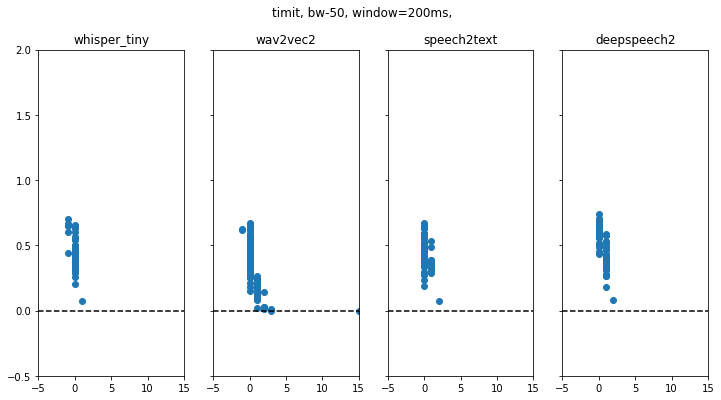

In [5]:
model_names = [
    'whisper_tiny',
    # 'whisper_base',
    # 'wav2letter_modified',

    'wav2vec2',
    'speech2text',
    'deepspeech2',
    ]
threshold = 0.5
mVocs = False
lmbda_column = 'opt_lmbda'
corr_column = 'test_cc_raw'
num_models = len(model_names)
fig, axes = plt.subplots(1, num_models, figsize=(12, 6), sharey=True)
lag = 200
bw = 50
for i, model_name in enumerate(model_names):
    identifier = 'ucsf_timit_trf_lags200_bw50_saving_for_qualitative'
    corr_obj = Correlations(model_name + '_' + identifier)
    data = corr_obj.data
    axes[i].scatter(data[lmbda_column], data[corr_column])
    axes[i].axhline(0, color='black', linestyle='--')
    axes[i].set_ylim(-0.5, 2)
    axes[i].set_xlim(-5, 15)
    axes[i].set_title(model_name)
title = "mVocs" if mVocs else "timit"
plt.suptitle(title+f", bw-{bw}, window={lag}ms,")

### visualize

In [2]:
from auditory_cortex.dataloader2 import DataLoader
from auditory_cortex.plotters.plotter_utils import PlotterUtils
from auditory_cortex.plotters import tikzplots
import auditory_cortex.utils as utils
from auditory_cortex.encoding import TRF
import auditory_cortex.io_utils.io as io

session = 200206
save_tikz = False
mVocs = False
sent_id = 308
plot_spectrogram = True
bin_width = 50


mean_line_width = 2
ind_trial_width = 1
alpha = 0.3

trial_color = 'gray'
mean_color = 'k'

model_name = 'wav2vec2'
lag = 200
dataset_name = 'ucsf'
shuffled = False


In [3]:
layers = {
    'wav2vec2': 6,
    'wav2letter_modified': 6,
    'deepspeech2': 2,
    'speech2text': 6,
    'whisper_tiny': 2,
    'whisper_base': 2
}
session = str(session)
dataset_obj = create_neural_dataset('ucsf', session)
dataloader = DataLoader(dataset_obj)
test_stim_ids = dataloader.get_testing_stim_ids(mVocs)
assert sent_id in test_stim_ids, "Invalid sent ID, choose from"+\
                f" {list(test_stim_ids)}"

spikes = dataloader.get_session_spikes(
    bin_width=bin_width, repeated=True, mVocs=mVocs
    )
all_trials_spike_counts = np.stack(
    [spikes[sent_id][ch] for ch in spikes[sent_id].keys()],
    axis=-1
    )


INFO:NeuralData:  Creating object for session: 200206 ... 
INFO:Done.


In [4]:
layer = layers[model_name]
    
# dataset_obj = create_neural_dataset('ucsf', session)
feature_extractor = create_feature_extractor(model_name, shuffled=False)
dataset = DNNDataAssembler(
    dataset_obj, feature_extractor, layer, bin_width=bin_width, mVocs=mVocs,
    )

Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You sho

INFO:creating Dataset for timit data.
INFO:Loading data for session at bin_width-50ms.
INFO:Reading features for model: wav2vec2
INFO:Resamping ANN features at bin-width: 50


In [5]:
saved_predictions = {}
prediction_colors = {}
trf_obj = TRF(model_name, dataset)

corr, opt_lag, opt_lmbda, trf_model = trf_obj.grid_search_CV(
        lags=[lag], tmin=0,
        num_folds=3,
        # test_trial=test_trial
    )

X, y = dataset.get_testing_data([sent_id])
saved_predictions[model_name] = trf_model.predict(X)[0]

# saved_predictions[model_name] = trf_obj.neural_prediction(
#         model_name, session, layer, bin_width, [sent_id], 'ucsf',
#         lag=lag
#     )[0]

prediction_colors[model_name] = PlotterUtils.get_model_specific_color(model_name)

INFO:TRF object created for 'wav2vec2' model.
INFO:
 Running for max lag=200 ms
INFO:
 For fold=0: 
INFO:GpuTRF object created with alpha=1e-05, tmin=0.0, tmax=0.2, sfreq=20.0
INFO:GpuTRF object created with alpha=0.0001, tmin=0.0, tmax=0.2, sfreq=20.0
INFO:GpuTRF object created with alpha=0.001, tmin=0.0, tmax=0.2, sfreq=20.0
INFO:GpuTRF object created with alpha=0.01, tmin=0.0, tmax=0.2, sfreq=20.0
INFO:GpuTRF object created with alpha=0.1, tmin=0.0, tmax=0.2, sfreq=20.0
INFO:GpuTRF object created with alpha=1.0, tmin=0.0, tmax=0.2, sfreq=20.0
INFO:GpuTRF object created with alpha=10.0, tmin=0.0, tmax=0.2, sfreq=20.0
INFO:GpuTRF object created with alpha=100.0, tmin=0.0, tmax=0.2, sfreq=20.0
INFO:GpuTRF object created with alpha=1000.0, tmin=0.0, tmax=0.2, sfreq=20.0
INFO:GpuTRF object created with alpha=10000.0, tmin=0.0, tmax=0.2, sfreq=20.0
INFO:GpuTRF object created with alpha=100000.0, tmin=0.0, tmax=0.2, sfreq=20.0
INFO:GpuTRF object created with alpha=1000000.0, tmin=0.0, tmax

In [ ]:
saved_predictions = {}
prediction_colors = {}
trf_obj = TRF(model_name, dataset)

corr, opt_lag, opt_lmbda, trf_model = trf_obj.grid_search_CV(
        lags=[lag], tmin=0,
        num_folds=3,
        # test_trial=test_trial
    )

X, y = dataset.get_testing_data([sent_id])
saved_predictions[model_name] = trf_model.predict(X)[0]

# saved_predictions[model_name] = trf_obj.neural_prediction(
#         model_name, session, layer, bin_width, [sent_id], 'ucsf',
#         lag=lag
#     )[0]

prediction_colors[model_name] = PlotterUtils.get_model_specific_color(model_name)

INFO:TRF object created for 'wav2vec2' model.
INFO:
 Running for max lag=200 ms
INFO:
 For fold=0: 
INFO:GpuTRF object created with alpha=1e-05, tmin=0.0, tmax=0.2, sfreq=20.0
INFO:GpuTRF object created with alpha=0.0001, tmin=0.0, tmax=0.2, sfreq=20.0
INFO:GpuTRF object created with alpha=0.001, tmin=0.0, tmax=0.2, sfreq=20.0
INFO:GpuTRF object created with alpha=0.01, tmin=0.0, tmax=0.2, sfreq=20.0
INFO:GpuTRF object created with alpha=0.1, tmin=0.0, tmax=0.2, sfreq=20.0
INFO:GpuTRF object created with alpha=1.0, tmin=0.0, tmax=0.2, sfreq=20.0
INFO:GpuTRF object created with alpha=10.0, tmin=0.0, tmax=0.2, sfreq=20.0
INFO:GpuTRF object created with alpha=100.0, tmin=0.0, tmax=0.2, sfreq=20.0
INFO:GpuTRF object created with alpha=1000.0, tmin=0.0, tmax=0.2, sfreq=20.0
INFO:GpuTRF object created with alpha=10000.0, tmin=0.0, tmax=0.2, sfreq=20.0
INFO:GpuTRF object created with alpha=100000.0, tmin=0.0, tmax=0.2, sfreq=20.0
INFO:GpuTRF object created with alpha=1000000.0, tmin=0.0, tmax

In [6]:
trf_model.X_mean_.shape, trf_model.X_std_.shape, trf_model.y_mean_.shape

((1, 2560), (1, 2560), (1, 64))

In [ ]:
getattr(trf_model, "normalize_X", True)

True

In [21]:
X, y = dataset.get_testing_data([sent_id])


In [23]:
y[0].shape

(11, 47, 64)

In [19]:
X_tmp,_ = trf_model._delay_and_reshape(X[0])
# Normalize after delay-and-reshape using stored mean/std with matching shape
# if hasattr(self, "X_mean_") and hasattr(self, "X_std_"):
if getattr(trf_model, "normalize_X", True):
    X_tmp = (X_tmp - trf_model.X_mean_) / trf_model.X_std_
xx = X_tmp[dataset.n_offset:]

In [24]:
yp = trf_model.models[0].predict(xx)

In [27]:
yp = yp + trf_model.y_mean_[:,0]

In [26]:
yp.shape

(47,)

In [25]:
trf_model.y_mean_[:,0].shape

(1,)

In [11]:
saved_predictions[model_name] + trf_model.y_mean_[0]

array([[3.36640948, 1.89601361, 4.6358616 , ..., 3.33479719, 6.99186811,
        5.6724044 ],
       [3.30410387, 1.50832969, 4.14031178, ..., 2.47919947, 4.88817938,
        3.89140111],
       [3.11368198, 1.49491194, 4.05981804, ..., 2.49223552, 4.68752948,
        4.2610569 ],
       ...,
       [3.27540762, 2.27357736, 4.72909024, ..., 3.70116541, 6.02852035,
        4.19010006],
       [2.93262066, 1.38500887, 4.92245066, ..., 2.51909515, 3.71974956,
        2.76687623],
       [2.26540349, 0.97739577, 4.01265953, ..., 1.5443066 , 2.92504207,
        2.2328973 ]])

0.1


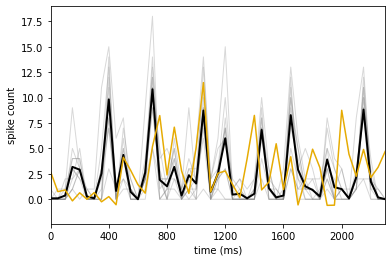

: 

In [ ]:
ch = 32
print(opt_lmbda[ch])
ax = tikzplots.plot_spike_counts(
        bin_width,
        ch, all_trials_spike_counts, saved_predictions,
        trial_color, mean_color, prediction_colors,
        ind_trial_width, mean_line_width, alpha=alpha
    )

In [31]:
opt_lmbda[61]

1.0

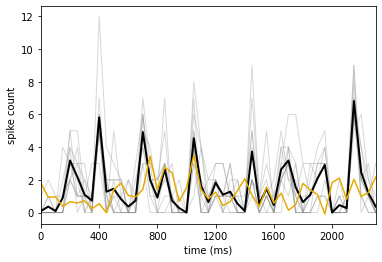

In [29]:
ch = 61
ax = tikzplots.plot_spike_counts(
        bin_width,
        ch, all_trials_spike_counts, saved_predictions,
        trial_color, mean_color, prediction_colors,
        ind_trial_width, mean_line_width, alpha=alpha
    )

In [21]:
trf_model = trf_obj.load_saved_model(
            model_name, session, layer, bin_width, shuffled=False,
            LPF=False, mVocs=mVocs, dataset_name=dataset_name,
            tmax=lag
            )

INFO:Reading TRF parameters for wav2vec2, session-200206,bin-width-50ms, shuffled-False, LPF-False, bias-False
INFO:Reading TRF parameters for wav2vec2, session-200206,bin-width-50ms, shuffled-False, LPF-False, bias-True
INFO:Reading from file: /scratch/gilbreth/ahmedb/cache/trf/wav2vec2/alphas/wav2vec2_layer_6_sess_200206_trf200_50ms.pkl
INFO:GpuTRF object created with alpha=[ 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
  1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
  1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 10.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
  1.   1.   1.   1.   0.1  1.   0.1  1. ], tmin=0, tmax=0.2, sfreq=20.0


In [26]:
biases = io.read_trf_parameters(
        model_name, session, bin_width, shuffled,
        verbose=False, LPF=False, mVocs=mVocs,
        bias=True, dataset_name=dataset_name,
        lag=lag
    )

INFO:Reading TRF parameters for wav2vec2, session-200206,bin-width-50ms, shuffled-False, LPF-False, bias-True


In [27]:
biases

{6: array([-2.12911673e-16, -4.14813872e-17,  1.31918196e-16, -3.06149380e-17,
         1.85003370e-16,  3.92390580e-16, -5.96595523e-16, -1.43239909e-16,
         8.83246471e-17,  1.04327455e-16, -1.65347458e-16, -1.99459407e-16,
        -1.91156266e-16, -4.91413294e-16,  1.66125416e-16, -2.30888244e-16,
         4.48531537e-16, -2.53886711e-16, -7.54924641e-17, -1.11607071e-16,
        -8.74975979e-17,  1.39216214e-16,  1.47177439e-16,  1.01701093e-16,
        -8.62576192e-16, -7.78290943e-17,  1.57370509e-16, -1.81367543e-16,
         2.17755776e-17,  3.15801959e-16, -6.75972279e-17, -3.44095768e-16,
        -1.74409750e-16, -6.30974518e-17,  1.54946838e-16,  5.38100507e-17,
        -3.07385281e-17,  1.00111994e-17, -2.78377954e-16, -6.17629443e-18,
         1.01742325e-16, -3.00914868e-16, -7.08130091e-17, -1.57612674e-16,
        -1.37965358e-16,  3.05686031e-17,  8.58106472e-17,  1.38318146e-16,
         5.02221945e-16, -6.80783534e-17,  2.64007234e-16, -4.28795152e-16,
        -

### correcting the regression...

In [7]:
tmin = 0
tmax = lag
sfreq = 1000 / bin_width
lmbda = 0.1

In [8]:
train_x, train_y = dataset.get_training_data()

In [10]:
from auditory_cortex.encoding import GpuTRF

trf_model = GpuTRF(
        tmin, tmax, sfreq, alpha=lmbda,
        )
trf_model.fit(X=train_x, y=train_y, n_offset=dataset.n_offset)

# save validation score for lmbda..
# lmbda_score[i] += trf_model.score(X=val_x, y=val_y, n_offset=self.dataset_assembler.n_offset)

INFO:GpuTRF object created with alpha=0.1, tmin=0, tmax=200, sfreq=20.0


: 